<a href="https://colab.research.google.com/github/leekangwoo8670/Jojungshi/blob/master/titanic_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

In [ ]:
train = pd.read_csv("/content/sample_data/train.csv")
submit = pd.read_csv("/content/sample_data/test.csv")

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
full_data = [train, submit]

In [ ]:
titanic = pd.concat([train, submit], axis=0).reset_index(drop=True)

1.Age

In [ ]:
titanic['Age'] = titanic.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

In [ ]:
titanic['Age'] = pd.cut(titanic['Age'].astype(int), 5)

In [ ]:
titanic['Age'].value_counts()

(16.0, 32.0]     752
(32.0, 48.0]     304
(-0.08, 16.0]    134
(48.0, 64.0]     106
(64.0, 80.0]      13
Name: Age, dtype: int64

2.Fare

In [ ]:
titanic.loc[titanic['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,"(48.0, 64.0]",0,0,3701,NaN,NaN,S


In [ ]:
Thomas = titanic.loc[(titanic['Pclass'] == 3) & (titanic['SibSp'] == 0) & (titanic['Embarked'] == 'S')]['Fare'].median()
print(Thomas)

7.925


In [ ]:
titanic.loc[titanic['Fare'].isnull(), 'Fare'] = Thomas

In [ ]:
titanic['Fare'] = pd.qcut(titanic['Fare'], 5)

In [ ]:
titanic['Fare'].value_counts()

(-0.001, 7.854]      275
(21.558, 41.579]     265
(41.579, 512.329]    259
(10.5, 21.558]       255
(7.854, 10.5]        255
Name: Fare, dtype: int64

3.Cabin

In [ ]:
print(titanic['Cabin'].unique())

[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148' 'B45' 'B36' 'A21' 'D34' 'A9' 'C31' 'B61' 'C5

In [ ]:
print(titanic['Cabin'].nunique())
print(titanic['Cabin'].isnull().sum())

186
1014


In [ ]:
titanic['Deck'] = titanic['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [ ]:
titanic[titanic['Pclass']==1]['Deck'].value_counts()

C    94
M    67
B    65
D    40
E    34
A    22
T     1
Name: Deck, dtype: int64

In [ ]:
titanic[titanic['Pclass']==2]['Deck'].value_counts()

M    254
F     13
D      6
E      4
Name: Deck, dtype: int64

In [ ]:
titanic[titanic['Pclass']==3]['Deck'].value_counts()

M    693
F      8
G      5
E      3
Name: Deck, dtype: int64

In [ ]:
titanic[titanic['Deck'] == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
339,340,0.0,1,"Blackwell, Mr. Stephen Weart",male,"(32.0, 48.0]",0,0,113784,"(21.558, 41.579]",T,S,T


In [ ]:
idx = titanic[titanic['Deck'] == 'T'].index
titanic.loc[idx, 'Deck'] = 'A'

In [ ]:
titanic['Deck'] = titanic['Deck'].replace(['A', 'B', 'C'], 'ABC')
titanic['Deck'] = titanic['Deck'].replace(['D', 'E'], 'DE')
titanic['Deck'] = titanic['Deck'].replace(['F', 'G'], 'FG')

titanic['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [ ]:
titanic.loc[(titanic['Pclass']==1) & (titanic['Deck']=='M'), 'Deck'] = 'ABC'
titanic.loc[(titanic['Pclass']==2) & (titanic['Deck']=='M'), 'Deck'] = 'DE'
titanic.loc[(titanic['Pclass']==3) & (titanic['Deck']=='M'), 'Deck'] = 'FG'

4.Ticket

In [ ]:
titanic['Ticket_type']=titanic['Ticket'].apply(lambda x: x[0:3])
titanic['Ticket_type']=titanic['Ticket_type'].astype('category')
titanic['Ticket_type']=titanic['Ticket_type'].cat.codes

In [ ]:
titanic['Word_count']=titanic['Name'].apply(lambda x: len(x.split()))

In [ ]:
titanic['Has_Cabin']=titanic['Cabin'].apply(lambda x: 0 if type(x)==float else 1)

5.Family_size

In [ ]:
titanic['Family_size'] = titanic['SibSp'] + titanic['Parch'] + 1

In [ ]:
titanic['isalone']=titanic['Family_size'].apply(lambda x: 0 if x>1 else 1)

In [ ]:
def get_title(name):
    title_search=re.search(' ([A-Za-z]+)\.', name)
    if title_search:
      return title_search.group(1)
    else:
      return ""

In [ ]:
titanic['Title']=titanic['Name'].apply(get_title)

In [ ]:
replace_to_rare=['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
replace_by_rule={'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'}

titanic['Title'] = titanic['Title'].replace(replace_to_rare, 'Rare')
titanic['Title'] = titanic['Title'].replace(replace_by_rule)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Ticket_type,Word_count,Has_Cabin,Family_size,isalone,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,"(16.0, 32.0]",1,0,A/5 21171,"(-0.001, 7.854]",NaN,S,FG,139,4,0,2,0,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,"(32.0, 48.0]",1,0,PC 17599,"(41.579, 512.329]",C85,C,ABC,154,7,1,2,0,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,"(16.0, 32.0]",0,0,STON/O2. 3101282,"(7.854, 10.5]",NaN,S,FG,165,3,0,1,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,"(32.0, 48.0]",1,0,113803,"(41.579, 512.329]",C123,S,ABC,3,7,1,2,0,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,"(32.0, 48.0]",0,0,373450,"(7.854, 10.5]",NaN,S,FG,108,4,0,1,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,"(16.0, 32.0]",0,0,A.5. 3236,"(7.854, 10.5]",NaN,S,FG,137,3,0,1,1,Mr
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,"(32.0, 48.0]",0,0,PC 17758,"(41.579, 512.329]",C105,C,ABC,154,5,1,1,1,Rare
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,"(32.0, 48.0]",0,0,SOTON/O.Q. 3101262,"(-0.001, 7.854]",NaN,S,FG,164,4,0,1,1,Mr
1307,1308,NaN,3,"Ware, Mr. Frederick",male,"(16.0, 32.0]",0,0,359309,"(7.854, 10.5]",NaN,S,FG,96,3,0,1,1,Mr


In [ ]:
titanic['Sex'] = titanic['Sex'].astype('category')
titanic['Sex'] = titanic['Sex'].cat.codes

In [ ]:
titanic['Fare'] = titanic['Fare'].astype('category')
titanic['Fare'] = titanic['Fare'].cat.codes

In [ ]:
titanic['Age'] = titanic['Age'].astype('category')
titanic['Age'] = titanic['Age'].cat.codes

In [ ]:
titanic['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [ ]:
titanic['Embarked'] = titanic['Embarked'].fillna('S')

In [ ]:
titanic['Embarked'] = titanic['Embarked'].astype('category')
titanic['Embarked'] = titanic['Embarked'].cat.codes

In [ ]:
titanic['Deck'] = titanic['Deck'].astype('category')
titanic['Deck'] = titanic['Deck'].cat.codes

In [ ]:
titanic['Title'] = titanic['Title'].astype('category')
titanic['Title'] = titanic['Title'].cat.codes

In [ ]:
titanic = titanic.drop(['PassengerId', 'Ticket', 'Cabin', 'Name'], axis=1)

In [ ]:
train = titanic.loc[:890]
test = titanic.loc[891:].drop(['Survived'], axis=1)

In [ ]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Ticket_type,Word_count,Has_Cabin,Family_size,isalone,Title
0,0.0,3,1,1,1,0,0,2,2,139,4,0,2,0,2
1,1.0,1,0,2,1,0,4,0,0,154,7,1,2,0,3
2,1.0,3,0,1,0,0,1,2,2,165,3,0,1,1,1
3,1.0,1,0,2,1,0,4,2,0,3,7,1,2,0,3
4,0.0,3,1,2,0,0,1,2,2,108,4,0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,2,1,1,0,0,2,2,1,25,3,0,1,1,4
887,1.0,1,0,1,0,0,3,2,0,2,4,1,1,1,1
888,0.0,3,0,1,1,2,3,2,2,167,5,0,4,0,1
889,1.0,1,1,1,0,0,3,0,0,1,4,1,1,1,2


In [ ]:
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Ticket_type,Word_count,Has_Cabin,Family_size,isalone,Title
891,3,1,2,0,0,0,1,2,81,3,0,1,1,2
892,3,0,2,1,0,0,2,2,98,5,0,2,0,3
893,2,1,3,0,0,1,1,1,45,4,0,1,1,2
894,3,1,1,0,0,1,2,2,77,3,0,1,1,2
895,3,0,1,1,1,2,2,2,74,6,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,1,1,0,0,1,2,2,137,3,0,1,1,2
1305,1,0,2,0,0,4,0,0,154,5,1,1,1,4
1306,3,1,2,0,0,0,2,2,164,4,0,1,1,2
1307,3,1,1,0,0,1,2,2,96,3,0,1,1,2


In [ ]:
x = train.drop(['Survived'], axis=1)
y = train['Survived']

In [ ]:
#x = pd.get_dummies(x, columns=x.columns)

In [ ]:
#test = pd.get_dummies(test, columns=test.columns)

In [ ]:
x

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Ticket_type,Word_count,Has_Cabin,Family_size,isalone,Title
0,3,1,1,1,0,0,2,2,139,4,0,2,0,2
1,1,0,2,1,0,4,0,0,154,7,1,2,0,3
2,3,0,1,0,0,1,2,2,165,3,0,1,1,1
3,1,0,2,1,0,4,2,0,3,7,1,2,0,3
4,3,1,2,0,0,1,2,2,108,4,0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,1,0,0,2,2,1,25,3,0,1,1,4
887,1,0,1,0,0,3,2,0,2,4,1,1,1,1
888,3,0,1,1,2,3,2,2,167,5,0,4,0,1
889,1,1,1,0,0,3,0,0,1,4,1,1,1,2


In [ ]:
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Ticket_type,Word_count,Has_Cabin,Family_size,isalone,Title
891,3,1,2,0,0,0,1,2,81,3,0,1,1,2
892,3,0,2,1,0,0,2,2,98,5,0,2,0,3
893,2,1,3,0,0,1,1,1,45,4,0,1,1,2
894,3,1,1,0,0,1,2,2,77,3,0,1,1,2
895,3,0,1,1,1,2,2,2,74,6,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,1,1,0,0,1,2,2,137,3,0,1,1,2
1305,1,0,2,0,0,4,0,0,154,5,1,1,1,4
1306,3,1,2,0,0,0,2,2,164,4,0,1,1,2
1307,3,1,1,0,0,1,2,2,96,3,0,1,1,2


In [ ]:
x.shape

(891, 14)

In [ ]:
test.shape

(418, 14)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)

In [ ]:
x_train.shape

(801, 14)

In [ ]:
from keras.layers import Dense, Activation, Dropout

In [ ]:
inputs = tf.keras.Input(shape=(x_train.shape[1],))

x1 = tf.keras.layers.Dense(512, activation='relu')(inputs)
#x1 = tf.keras.layers.Dropout(0.5)(x1)
x1 = tf.keras.layers.Dense(64, activation='relu')(x1)
#x1 = tf.keras.layers.Dropout(0.5)(x1)
x1 = tf.keras.layers.Dense(10, activation='relu')(x1)
#x1 = tf.keras.layers.Dropout(0.5)(x1)

x2 = tf.keras.layers.Dense(64, activation='relu')(inputs)
#x2 = tf.keras.layers.Dropout(0.5)(x2)
x2 = tf.keras.layers.Dense(512, activation='relu')(x2)
#x2 = tf.keras.layers.Dropout(0.5)(x2)
x2 = tf.keras.layers.Dense(10, activation='relu')(x2)
#x2 = tf.keras.layers.Dropout(0.5)(x2)

x3 = tf.keras.layers.Dense(128, activation='relu')(inputs)
#x3 = tf.keras.layers.Dropout(0.5)(x3)
x3 = tf.keras.layers.Dense(128, activation='relu')(x3)
#x3 = tf.keras.layers.Dropout(0.5)(x3)
x3 = tf.keras.layers.Dense(10, activation='relu')(x3)
#x3 = tf.keras.layers.Dropout(0.5)(x3)

#x4 = tf.keras.layers.Dense(128, activation='relu')(inputs)
#x4 = tf.keras.layers.Dropout(0.3)(x4)
#x4 = tf.keras.layers.Dense(64, activation='relu')(x4)
#x4 = tf.keras.layers.Dropout(0.3)(x4)
#x4 = tf.keras.layers.Dense(32, activation='relu')(x4)
#x4 = tf.keras.layers.Dropout(0.3)(x4)

x = tf.keras.layers.concatenate([inputs, x1, x2, x3], axis=1)
x = tf.keras.layers.Dense(64, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 14)]         0                                            
__________________________________________________________________________________________________
dense_366 (Dense)               (None, 512)          7680        input_29[0][0]                   
__________________________________________________________________________________________________
dense_369 (Dense)               (None, 64)           960         input_29[0][0]                   
__________________________________________________________________________________________________
dense_372 (Dense)               (None, 128)          1920        input_29[0][0]                   
___________________________________________________________________________________________

In [ ]:
history = model.fit(x_train, y_train, shuffle=True, epochs=200, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/200
45/45 [==============================] - 0s 6ms/step - loss: 0.4241 - accuracy: 0.8139 - val_loss: 0.4319 - val_accuracy: 0.8025
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 0.4198 - accuracy: 0.8264 - val_loss: 0.4292 - val_accuracy: 0.8025
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 0.4283 - accuracy: 0.8153 - val_loss: 0.4343 - val_accuracy: 0.8148
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 0.4249 - accuracy: 0.8125 - val_loss: 0.4377 - val_accuracy: 0.8148
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 0.4269 - accuracy: 0.8056 - val_loss: 0.4301 - val_accuracy: 0.8025
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 0.4225 - accuracy: 0.8153 - val_loss: 0.4377 - val_accuracy: 0.8025
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 0.4243 - accuracy: 0.8208 - val_loss: 0.4365 - val_accuracy: 0.8025
Epoch 8/200
4

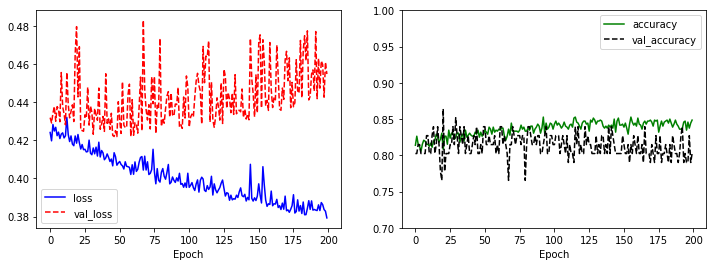

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

In [ ]:
model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 0.4948 - accuracy: 0.7778


[0.4947624206542969, 0.7777777910232544]

In [ ]:
test_pred = model.predict(test)

In [ ]:
test_pred_argmax = np.argmax(test_pred, axis=1)

In [ ]:
test_pred_argmax

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
sub = submit['PassengerId']

In [ ]:
sub = pd.concat([sub, pd.DataFrame(test_pred_argmax, columns=['Survived'])], axis=1)

In [ ]:
sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
sub.to_csv("/content/sample_data/titanic_0301.csv", index=False)

In [ ]:
jun = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1])

In [ ]:
sub1 = submit['PassengerId']
sub1 = pd.concat([sub1, pd.DataFrame(jun, columns=['Survived'])], axis=1)

In [ ]:
sub1

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
sub1.to_csv("/content/sample_data/titanic_jun.csv", index=False)